# Navier Plate

In this example we model a so called Navier plate, simply supported on all edges, under the effect varius loads. We run run a linear analysis and do some plotting.

***

## Create a COM interface to a new instance of AxisVM

In [1]:
from axisvm.com.client import start_AxisVM
import axisvm.com.tlb as axtlb
axvm = start_AxisVM(visible=True, daemon=True)


In [2]:
axvm.__class__

axisvm.com.axapp.IAxisVMApplication

Create a new model and set the working directory. An empty string means the directory where AxisVM.exe is located:

In [3]:
modelId = axvm.Models.New()
axm = axvm.Models.Item[modelId]
wdir = ""


## Material

Set Eurocode as the standard and "C16/20" concrete form the material library.

In [4]:
axm.Settings.NationalDesignCode = axtlb.ndcEuroCode
matId = axm.Materials.AddFromCatalog(axtlb.ndcEuroCode, "C16/20")


## Geometry

The definition of a geometry of a model follows a hierarchical workflow. This means, that we cannot directly define the domains. Instead, we first define the nodes that make up the lines, with which finally we define the domains.

We create the beam as two touching domains, which makes up for a total of 6 nodes. We also store the indices of the defined nodes as a reference for creating the lines.

In [5]:
import numpy as np
from axisvm.com.tlb import dofPlateXY

Lx, Ly = 8., 6.  # side lengths
t = 0.2  # thickness

# the plate is in the x-y plane
# the origo is located at the left bottom corner
coords = np.zeros((4, 3))  # we have four points in 3d space
coords[0, :] = 0., 0., 0.
coords[1, :] = Lx, 0., 0.
coords[2, :] = Lx, Ly, 0.
coords[3, :] = 0., Ly, 0.

fnc = axm.Nodes.AddWithDOF
nodeIDs = list(map(lambda c: fnc(*c, dofPlateXY), coords))


We define the lines that make up the domains and store their indices in a `list`. 

In [6]:
nodes_of_lines = [[0, 1], [1, 2], [2, 3], [3, 0]]
LineGeomType = axtlb.lgtStraightLine
lineIDs = []
for line in nodes_of_lines:
    lineIDs.append(axm.Lines.Add(nodeIDs[line[0]], nodeIDs[line[1]],
                   LineGeomType, axtlb.RLineGeomData())[1])


Now we are in a position to create the domains by providing lineIDs.

In [7]:
from axisvm.com.tlb import RSurfaceAttr, lnlTensionAndCompression, \
    RResistancesXYZ, schLinear, stPlate, RElasticFoundationXYZ, \
    RNonLinearityXYZ

sattr = RSurfaceAttr(
    Thickness=t,
    SurfaceType=stPlate,
    RefZId=0,
    RefXId=0,
    MaterialId=matId,
    ElasticFoundation=RElasticFoundationXYZ(0, 0, 0),
    NonLinearity=RNonLinearityXYZ(lnlTensionAndCompression,
                                  lnlTensionAndCompression,
                                  lnlTensionAndCompression),
    Resistance=RResistancesXYZ(0, 0, 0),
    Charactersitics=schLinear)

_ = axm.Domains.Add(LineIds=lineIDs, SurfaceAttr=sattr)


## Loads

Load Case 1 - Constant distributed vertical load on the whole domain

In [8]:
lcid1 = 1
axm.LoadCases.Name[1] = 'LC1'

In [9]:
qz = -1.0  # load intensity

LoadDomainConstant = axtlb.RLoadDomainConstant(
    LoadCaseId=lcid1,
    DomainId=1,
    qx=0,
    qy=0,
    qz=qz,
    DistributionType=axtlb.sddtSurface,
    SystemGLR=axtlb.sysGlobal
)
_ = axm.Loads.AddDomainConstant(LoadDomainConstant)


Load Case 2 - Constant distributed vertical load over a rectangular patch

In [10]:
lcid2 = axm.LoadCases.Add('LC2', axtlb.lctStandard)

In [11]:
from axisvm.com.tlb import RLoadDomainPolyArea, dtGlobal, \
    ldtConst

xc, yc, w, h = 2*Lx/3, Ly/2, Lx/5, Ly/3
qz = -2.0  # load intensity

# origo is located at the left bottom corner
patchlines = axvm.ObjectCreator.NewLines3d()
patchline1 = axtlb.RLine3d(
    LineType=axtlb.ltStraightLine3d,
    P1=axtlb.RPoint3d(xc-w/2, yc-h/2, 0),
    P2=axtlb.RPoint3d(xc+w/2, yc-h/2, 0)
)
patchline2 = axtlb.RLine3d(
    LineType=axtlb.ltStraightLine3d,
    P1=axtlb.RPoint3d(xc+w/2, yc-h/2, 0),
    P2=axtlb.RPoint3d(xc+w/2, yc+h/2, 0)
)
patchline3 = axtlb.RLine3d(
    LineType=axtlb.ltStraightLine3d,
    P1=axtlb.RPoint3d(xc+w/2, yc+h/2, 0),
    P2=axtlb.RPoint3d(xc-w/2, yc+h/2, 0)
)
patchline4 = axtlb.RLine3d(
    LineType=axtlb.ltStraightLine3d,
    P1=axtlb.RPoint3d(xc-w/2, yc+h/2, 0),
    P2=axtlb.RPoint3d(xc-w/2, yc-h/2, 0)
)
patchlines.Add(patchline1)
patchlines.Add(patchline2)
patchlines.Add(patchline3)
patchlines.Add(patchline4)

RectPatch = RLoadDomainPolyArea(
    LoadCaseId=lcid2,
    DistributionType=dtGlobal,
    LoadDistributionType=ldtConst,
    Component=2,  # z direction
    P1=qz,
    WindowLoad=True
)

_ = axm.Loads.AddDomainPolyArea(patchlines, RectPatch)

Load Case 3 - Vertical concentrated load

In [12]:
lcid3 = axm.LoadCases.Add('LC3', axtlb.lctStandard)

In [13]:
from axisvm.com.tlb import RLoadDomainConcentrated

Fz = -10
xF, yF = Lx/3, 2*Ly/3

concload = RLoadDomainConcentrated(
    LoadCaseId=lcid3,
    DomainId=1,
    Fz=Fz,
    x=xF, y=yF,
    ReferenceId=0  # global
)

_ = axm.Loads.AddDomainConcentrated(concload)

## Load Combinations

In [14]:
lcomb1 = axm.LoadCombinations.Add('ULS1', axtlb.ctULS1, 
                                  [1.5, 0, 0.9], [lcid1, lcid2, lcid3])

## Supports

We add two hinged supports at the ends.

In [15]:
Stiffnesses = axtlb.RStiffnesses(
    x=1e12,
    y=1e12,
    z=1e12,
    xx=0,
    yy=0,
    zz=0
)
NonLinearity = axtlb.RNonLinearity(
    x=axtlb.lnlTensionAndCompression,
    y=axtlb.lnlTensionAndCompression,
    z=axtlb.lnlTensionAndCompression,
    xx=axtlb.lnlTensionAndCompression,
    yy=axtlb.lnlTensionAndCompression,
    zz=axtlb.lnlTensionAndCompression
)
Resistances = axtlb.RResistances(
    x=0,
    y=0,
    z=0,
    xx=0,
    yy=0,
    zz=0
)
_ = axm.LineSupports.AddEdgeRelative(Stiffnesses, NonLinearity,
                                     Resistances, 1, 0, 0, 1, 0)
_ = axm.LineSupports.AddEdgeRelative(Stiffnesses, NonLinearity,
                                     Resistances, 2, 0, 0, 1, 0)
_ = axm.LineSupports.AddEdgeRelative(Stiffnesses, NonLinearity,
                                     Resistances, 3, 0, 0, 1, 0)
_ = axm.LineSupports.AddEdgeRelative(Stiffnesses, NonLinearity,
                                     Resistances, 4, 0, 0, 1, 0)


## Meshing

We define a triangle mesh, fitted to both concentrated and distributed areaa loads.

In [16]:
MeshParams = axtlb.RDomainMeshParameters(
    MeshSize=min([Lx/10, Ly/10]),
    MeshType=axtlb.mtUniform,
    MeshGeometryType=axtlb.mgtTriangle,
    IsFitToPointLoad=True,
    FitToPointLoad=0.,  # fit to all loads
    IsFitToSurfaceLoad=True,
    FitToSurfaceLoad=0.,  # fit to all loads
)
axm.Domains[:].GenerateMesh(MeshParams);

Notice the use of the semicolon here. This simplifies carrying out the same operation over a range of domains. (the colon at the end simply suppresses the output).

## Processing

We save the file and run a linear analysis, with all warnings suppressed.

In [17]:
fpath = wdir + 'Navier.axs'
axm.SaveToFile(fpath, False)
axm.Calculation.LinearAnalysis(axtlb.cuiNoUserInteractionWithAutoCorrectNoShow)


1

## Plotting with AxisVM

We plot vertical displacements of the previously defined load combination. At the end we save the plot to a file in the working directory.

In [18]:
# we want the domain to fill up the screen entirely
axm.View = axtlb.vTop
axm.FitInView()

# turn off the grid
GridOptions = axtlb.RGridOptions(DisplayGrid=False)
axm.Settings.SetGridOptions(GridOptions)

WriteValuesTo = axtlb.RWriteValuesTo(
    Nodes=False,
    Lines=False,
    Surfaces=True,
    MinMaxOnly=True
)

BasicDispParams = axtlb.RBasicDisplayParameters_V153(
    ResultComponent=axtlb.rc_d_eZ,
    Scale=1.0,
    DisplayMode=axtlb.dmIsosurfaces2D,
    DisplayShape=axtlb.dsDeformed,
    WriteValuesTo=WriteValuesTo
)

ExtDispParams = axtlb.RExtendedDisplayParameters_V153(
    BasicDispParams=BasicDispParams,
    DisplayAnalysisType=axtlb.datLinear,
    ResultType=axtlb.rtLoadCombination
)
axm.Windows.SetStaticDisplayParameters_V153(1, ExtDispParams, lcomb1, [])

axm.Windows.ReDraw()
imgpath = wdir + 'Navier_ez.bmp'
axm.Windows[1].SaveWindowToBitmap(axtlb.wcmColour, imgpath)


1

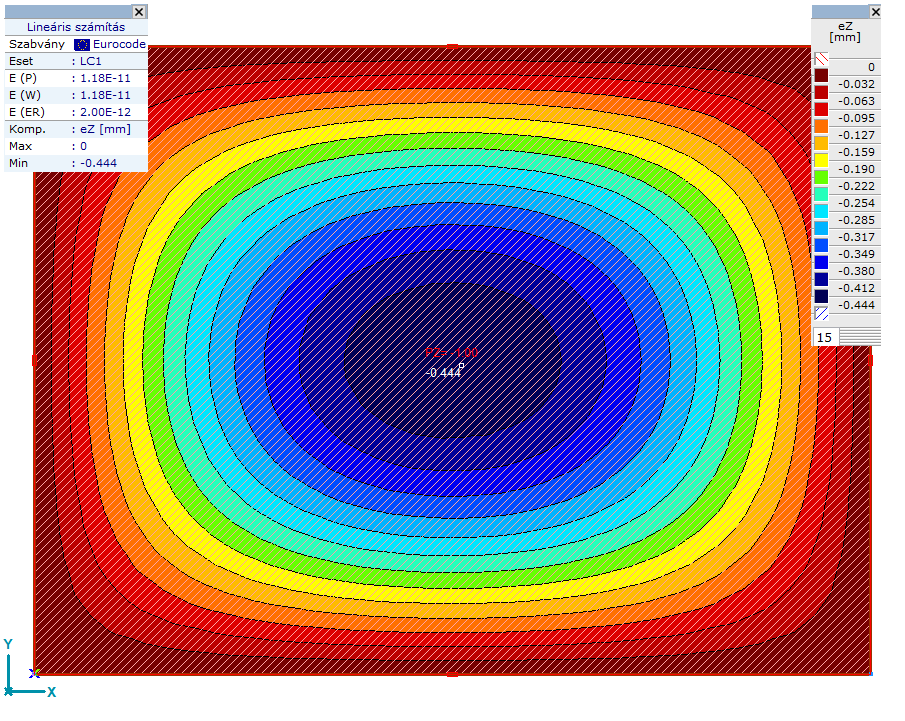

In [19]:
axvm.BringToFront()
axm.View = axtlb.vTop
axvm.MainFormTab = axtlb.mftStatic
axm.FitInView()
axm.Windows[1].screenshot()

## Close AxisVM

Because we created the interface with `daemon=True`, the application closes without any warning.

In [20]:
axvm.Quit()